In [ ]:
from pyspark.ml.feature import *
from pyspark.sql.functions import *
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Window
from pyspark.sql.types import *

import pandas as pd
import numpy as np
from scipy import stats
import pyspark.pandas as ps

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import random

from collections import Counter

from datetime import date

###Functions

In [ ]:
def check(x):
  if x/10000000 >= 1:
    return str(float(np.round(x/10000000,1))) + 'Cr'
  elif x/100000 >= 1:
    return str(float(np.round(x/100000,1))) + 'L'
  elif x/1000 >= 1:
    return str(int(np.round(x/1000,0))) + 'K'
  else:
    return x

In [ ]:
# banding(df, 'id', 'approved_flag', 'etb_vintage', 0, 120, 12, 12, 5)
def banding(df, idx, target, clm, min, max, inc, x1, y1):

  i = min 
  j = 1 

  fin_clm = clm + '_band'

  sdig = lambda x: '0' + str(x) if len(str(x))==1 else str(x)
  
  temp_df = df.select([idx, target, clm])

  new_df = spark.createDataFrame(data=[], schema = temp_df.schema).withColumn(fin_clm, lit(None).cast(StringType()))

  while(i <= max):
    jf = sdig(j)
    if i+inc >= max:
      x = check(i)
      y = check(max)  
      temp_df1 = temp_df.filter((col(clm)>=i) & (col(clm)<=max)).withColumn(fin_clm, lit(f'{jf}. {x}-{y}'))
      new_df = new_df.union(temp_df1)
      temp_df1 = temp_df.filter((col(clm)>max)).withColumn(fin_clm, lit(f'{sdig(j+1)}. {y}<'))
      new_df = new_df.union(temp_df1)
      break
    else:
      x = check(i)
      y = check(i+inc-1)
      temp_df1 = temp_df.filter((col(clm)>=i) & (col(clm)<i+inc)).withColumn(fin_clm, lit(f'{jf}. {x}-{y}'))
      new_df = new_df.union(temp_df1)

    j = j+1
    i = i + inc

  display(new_df.groupBy(fin_clm).agg(count(target).alias('Count'), sum(target).alias('Unsecured')).withColumn('%age', round((col('Unsecured')/col('Count'))*100, 2)))
  new_df = new_df.groupBy(fin_clm).agg(count(target).alias('Count'), sum(target).alias('Unsecured')).toPandas()

  df_final1 = new_df.groupby([fin_clm]).apply(lambda x: x['Unsecured']/x['Count']).reset_index(name='Unsecured')    
  df_final2 = new_df.groupby([fin_clm])['Count'].sum().reset_index(name='Count') 
  
  fig, ax1 = plt.subplots()

  color = '#6EC5C5'
  ax1.set_xlabel(col, color='w')
  ax1.set_ylabel("Count", color=color)
  ax1.bar(df_final2[fin_clm], df_final2['Count'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  

  color = '#BB8F71'
  ax2.set_ylabel('%age', color=color) 
  ax2.plot(df_final1[fin_clm], df_final1['Unsecured'], '-o', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.set_figheight(y1)
  fig.set_figwidth(x1) 

  fig.tight_layout()
  fig.set_facecolor('#1F272D')
  ax1.set_facecolor('xkcd:black')
  for spine in ax2.spines.values():
        spine.set_edgecolor('xkcd:white')      
  ax1.tick_params(axis='x', colors='xkcd:white')  # otherwise the right y-label is slightly clipped
  plt.show()


In [ ]:
# custom_banding(new_df,'id','approved_flag','v3_score_band',12,5)
def custom_banding(df, idx, target, fin_clm, x1, y1):
  
  display(df.groupBy(fin_clm).agg(count(target).alias('Count'), sum(target).alias('Unsecured')).withColumn('%age', round((col('Unsecured')/col('Count'))*100, 2)))

  new_df = df.select([idx, target, fin_clm])

  new_df = new_df.groupBy(fin_clm).agg(count(target).alias('Count'), sum(target).alias('Unsecured')).toPandas()

  df_final1 = new_df.groupby([fin_clm]).apply(lambda x: x['Unsecured']/x['Count']).reset_index(name='Unsecured')    
  df_final2 = new_df.groupby([fin_clm])['Count'].sum().reset_index(name='Count') 
  
  fig, ax1 = plt.subplots()

  color = '#6EC5C5'
  ax1.set_xlabel(col, color='white')
  ax1.set_ylabel("Count", color=color)
  ax1.bar(df_final2[fin_clm], df_final2['Count'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  

  color = '#BB8F71'
  ax2.set_ylabel('%age', color=color) 
  ax2.plot(df_final1[fin_clm], df_final1['Unsecured'], '-o', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.set_figheight(y1)
  fig.set_figwidth(x1) 

  fig.tight_layout()
  fig.set_facecolor('#1F272D')
  ax1.set_facecolor('xkcd:black')
  for spine in ax2.spines.values():
        spine.set_edgecolor('xkcd:white')      
  ax1.tick_params(axis='x', colors='xkcd:white')  # otherwise the right y-label is slightly clipped
  plt.show()

###Feature Selection (Graphs)

In [ ]:
# business = ['BL DIRECT','BL INDIRECT']

In [ ]:
df = spark.sql('select uuid() as id,* from bfl_std_lake.sme_coe.zm_unsec_login_aa_l12m_base_ctype_bcid_aa_etb_all_vars')

etb_total_pos_band,Count,Unsecured,%age
02. 2.0L-4.0L,19474,6068,31.16
03. 4.0L-6.0L,15013,5351,35.64
04. 6.0L-8.0L,10348,3957,38.24
05. 8.0L-10.0L,7188,2907,40.44
06. 10.0L<,22720,8803,38.75
01. 1K-2.0L,52268,15361,29.39


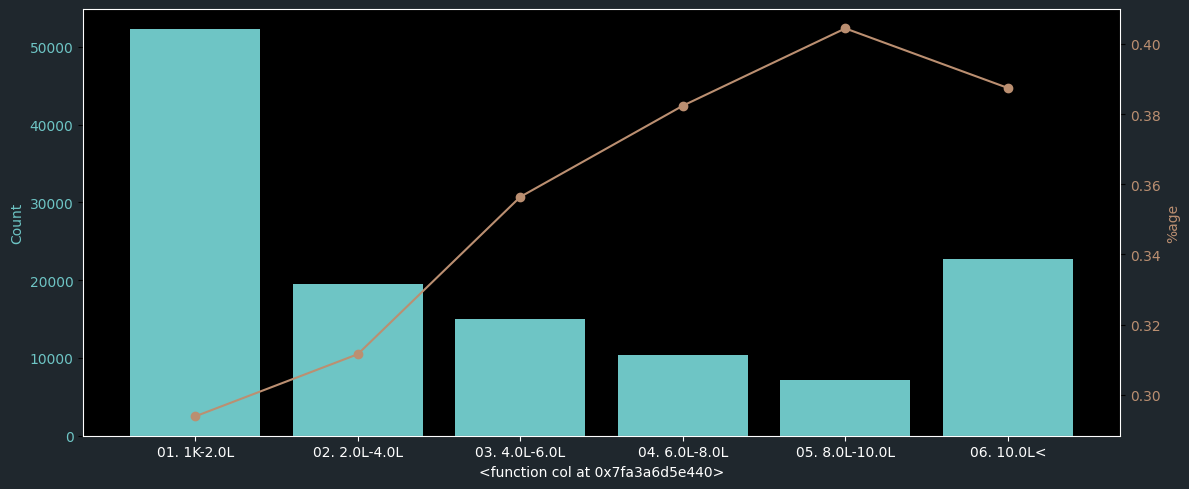

In [ ]:
banding(df,'id','approved_flag','etb_total_pos',1000,1000000,200000,12,5)

enq_unsec_l12m_band,Count,Unsecured,%age
03. 4-5,19199,4951,25.79
04. 6-7,12547,2763,22.02
05. 8-10,11970,2324,19.42
06. 10<,28635,3497,12.21
01. 0-1,80964,37008,45.71
02. 2-3,33361,11096,33.26


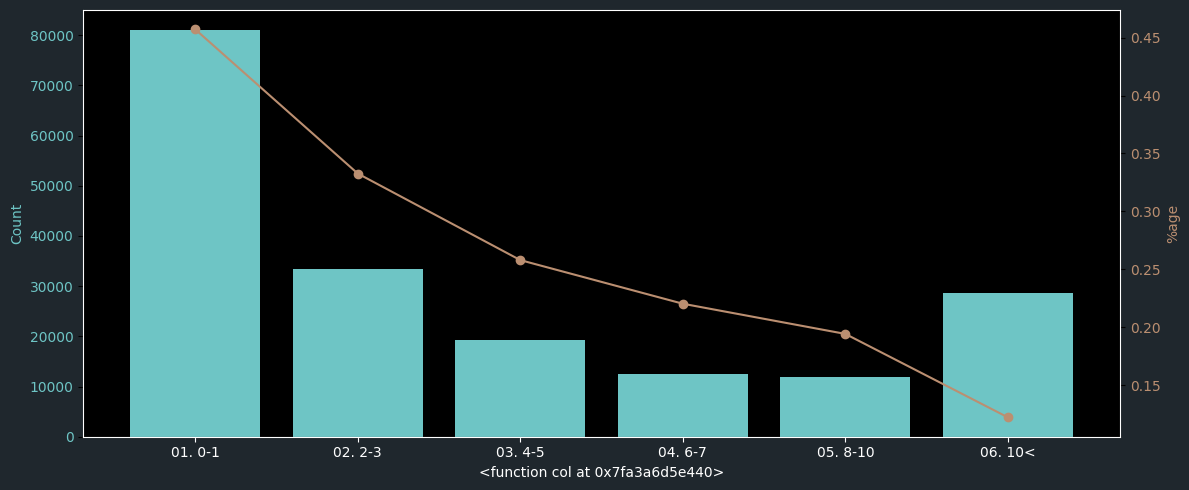

In [ ]:
banding(df,'id','approved_flag','enq_unsec_l12m',0,10,2,12,5)

bureau_vintage_band,Count,Unsecured,%age
01. 0-23,8048,2510,31.19
02. 24-47,19572,5713,29.19
03. 48-71,27366,8382,30.63
04. 72-95,29126,9483,32.56
05. 96-119,25561,8582,33.57
06. 120-143,21033,7298,34.7
07. 144-167,16143,5693,35.27
08. 168-191,9878,3610,36.55
09. 192-215,13146,4847,36.87
10. 216-240,11716,4364,37.25


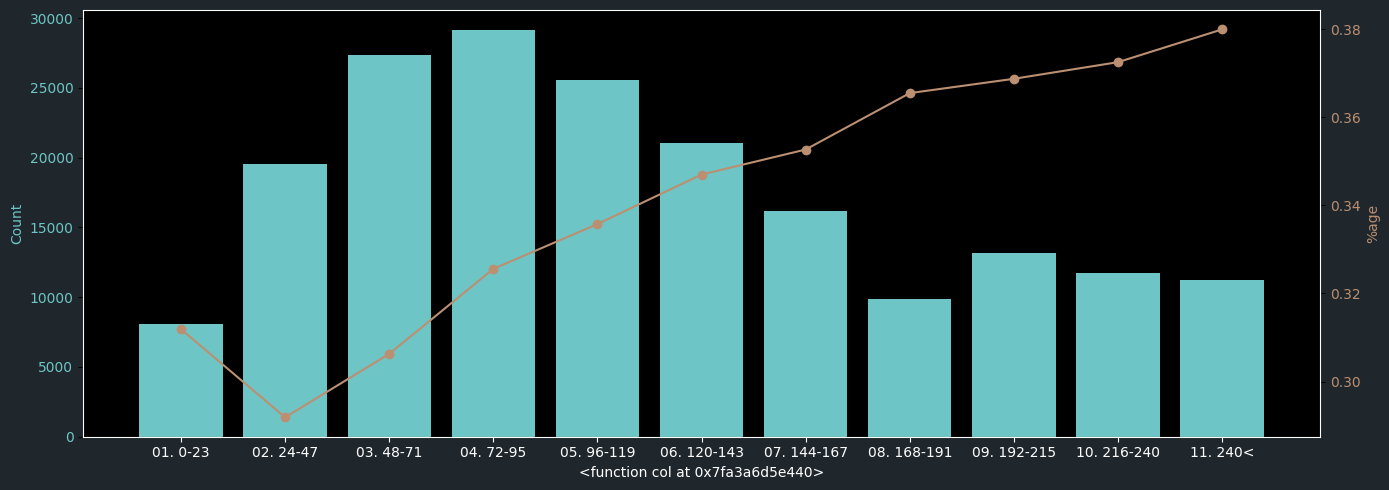

In [ ]:
banding(df,'id','approved_flag','bureau_vintage',0,240,24,14,5)

avg_all_days_l3m_band,Count,Unsecured,%age
02. 20K-40K,16061,4225,26.31
03. 40K-60K,9733,2770,28.46
04. 60K-80K,6534,2044,31.28
05. 80K-100K,4946,1638,33.12
06. 1.0L-1.2L,3854,1304,33.83
07. 1.2L-1.4L,2967,1069,36.03
08. 1.4L-1.6L,2488,902,36.25
09. 1.6L-1.8L,2102,791,37.63
10. 1.8L-2.0L,1740,677,38.91
11. 2.0L<,22067,9802,44.42


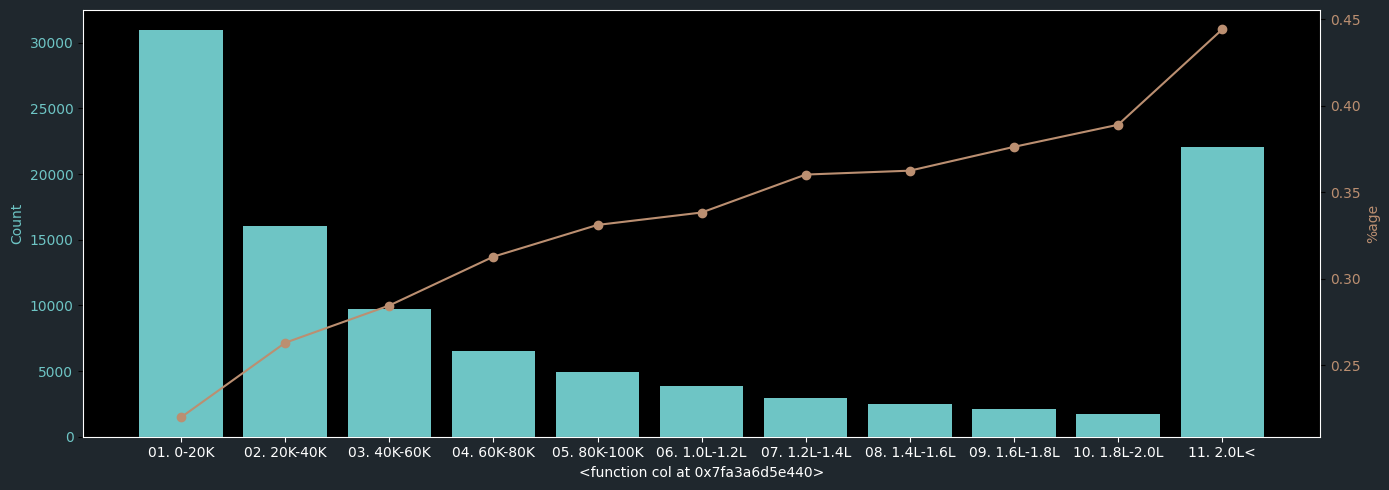

In [ ]:
banding(df,'id','approved_flag','avg_all_days_l3m',0,200000,20000,14,5)

TOTAL_CREDIT_L6M_AMT_band,Count,Unsecured,%age
01. 0-10.0L,27466,6682,24.33
02. 10.0L-20.0L,21697,5614,25.87
03. 20.0L-30.0L,13622,3858,28.32
04. 30.0L-40.0L,9221,2883,31.27
05. 40.0L-50.0L,6628,2208,33.31
06. 50.0L-60.0L,5010,1751,34.95
07. 60.0L-70.0L,3786,1364,36.03
08. 70.0L-80.0L,3049,1188,38.96
09. 80.0L-90.0L,2445,944,38.61
10. 90.0L-1.0Cr,2068,832,40.23


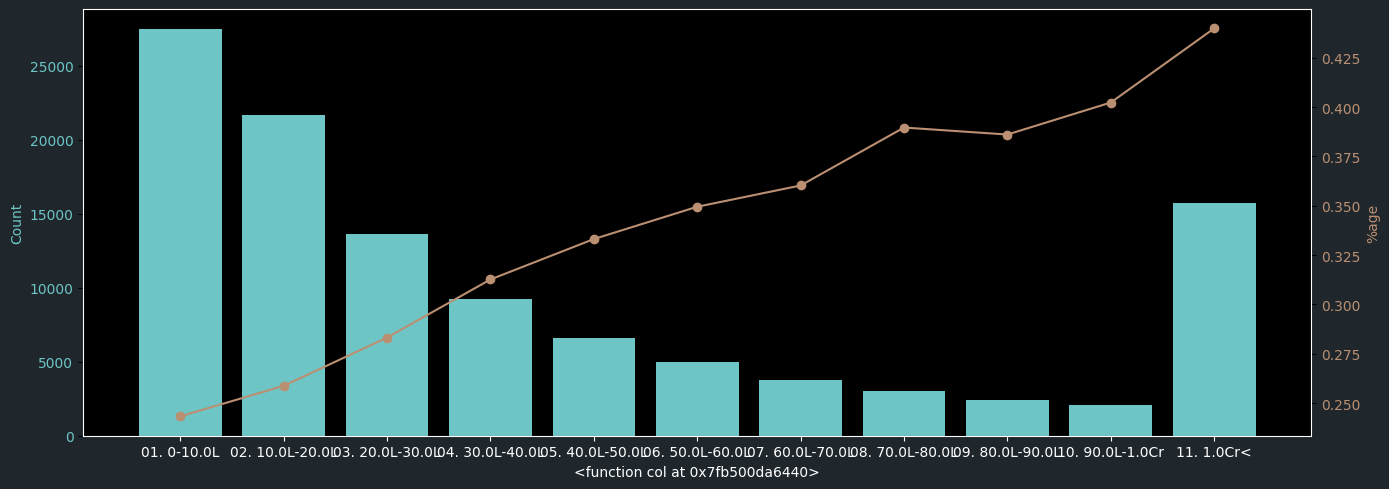

In [ ]:
banding(df,'id','approved_flag','TOTAL_CREDIT_L6M_AMT',0,10000000,1000000,14,5)

min_balanceAsOf10th_l6m_band,Count,Unsecured,%age
01. 1K-3K,17556,5378,30.63
02. 4K-6K,7525,2505,33.29
03. 6K-8K,4391,1554,35.39
04. 8K-11K,3715,1399,37.66
05. 11K-13K,2497,990,39.65
06. 14K-16K,1828,724,39.61
07. 16K-18K,1378,553,40.13
08. 18K-20K,729,293,40.19
09. 20K<,16426,7659,46.63


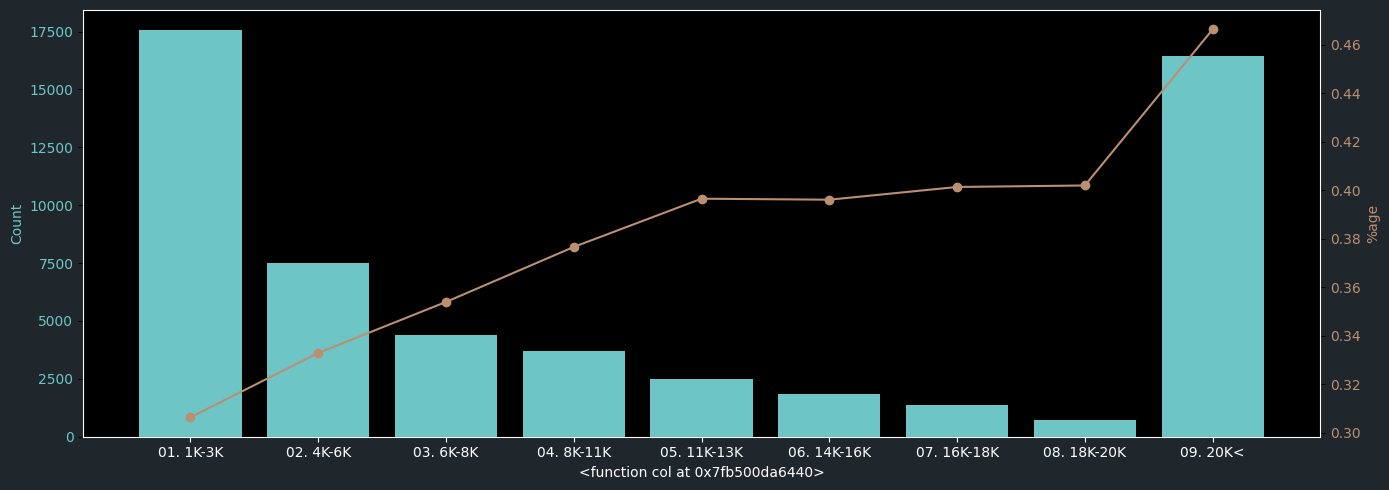

In [ ]:
banding(df,'id','approved_flag','min_balanceAsOf10th_l6m',1000,20000,2500,14,5)

nob_gst_cat,Count,Unsecured,%age
Services,20088,6789,33.8
NA,47522,12851,27.04
Trading,131939,48816,37.0
Manufacturing,8633,3429,39.72


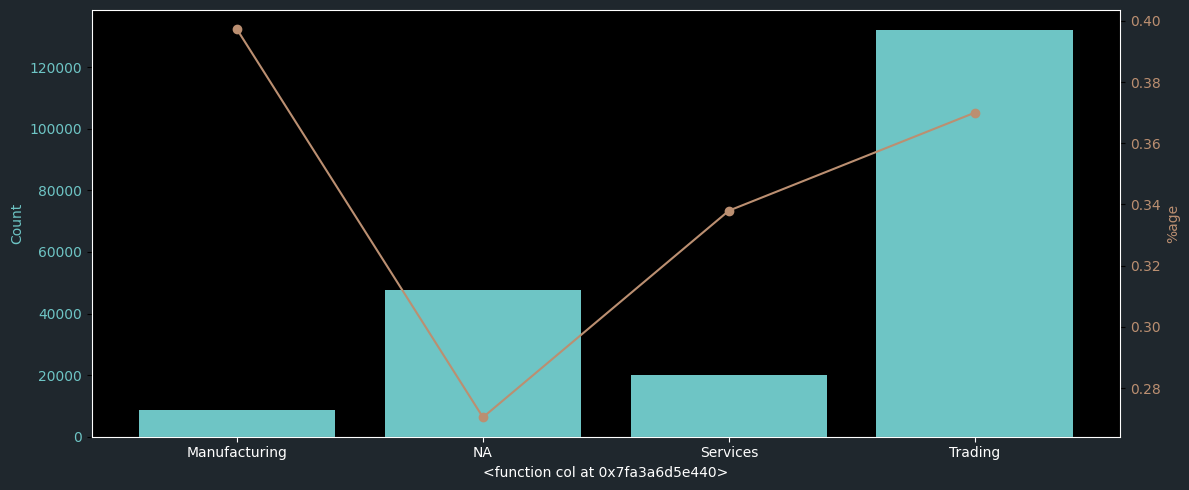

In [ ]:
custom_banding(df,'id','approved_flag','nob_gst_cat',12,5)

gst_pan_total_to,Count,Unsecured,%age
50CR - 100CR,502,253,50.4
10CR - 25CR,5875,2911,49.55
75L - 1 CR,12071,4977,41.23
null,31686,7142,22.54
35L - 40 L,4691,1636,34.88
25CR - 50CR,1585,760,47.95
1.25CR - 1.5 CR,7048,3093,43.88
Unknown,7061,1542,21.84
25L - 30 L,5668,1807,31.88
0 - 5 L,21148,4441,21.0


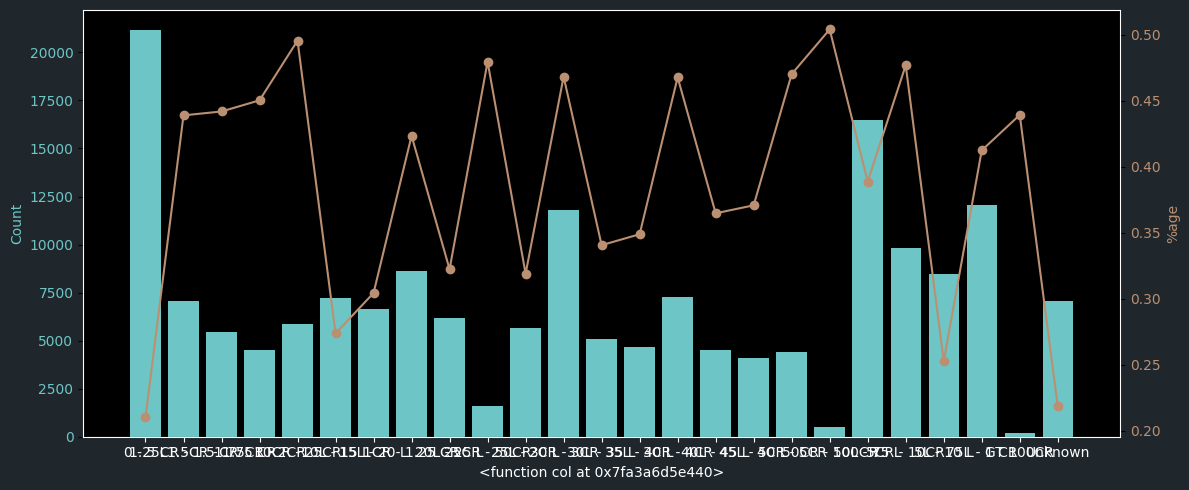

In [ ]:
custom_banding(df,'id','approved_flag','gst_pan_total_to',12,5)

pge,Count,Secured,%age
OTHERS,114796,2668,2.32
null,5661,86,1.52
EMERGING_1,24269,843,3.47
GROWTH,90804,3373,3.71
EMERGING_2,87846,2593,2.95
PRIME,127941,5372,4.2


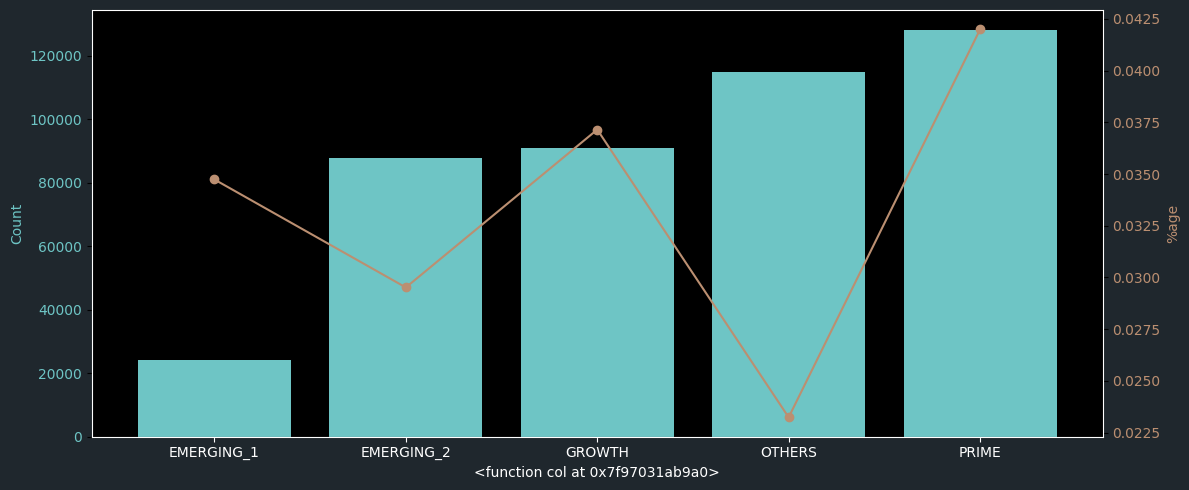

In [ ]:
custom_banding(df,'id','approved_flag','pge',12,5)

customertype,Count,Secured,%age
NTB,30479,319,1.05
ETBL,21390,1626,7.6
PTB,87789,2259,2.57
ETB,311659,10731,3.44


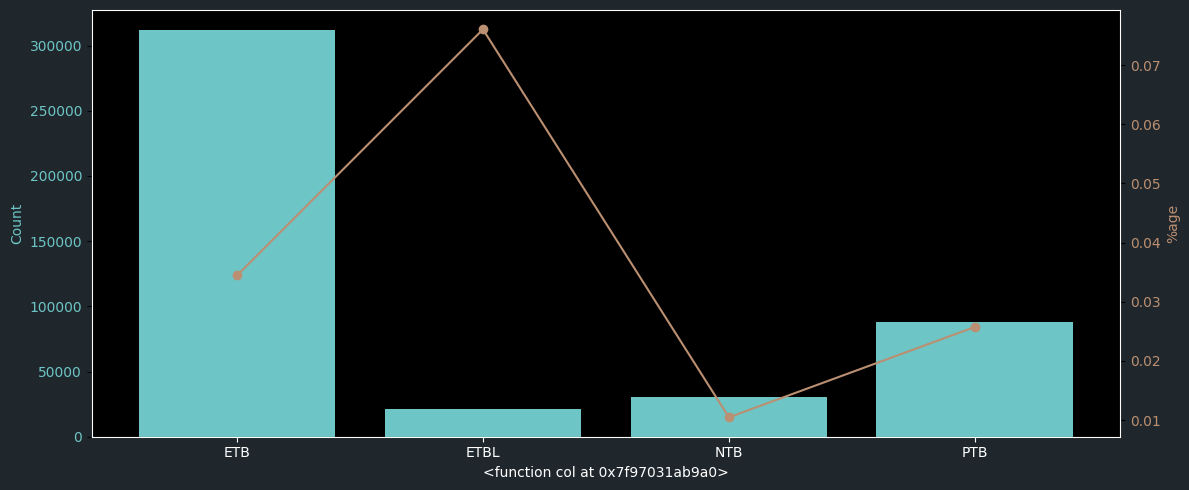

In [ ]:
custom_banding(df,'id','approved_flag','customertype',12,5)